## Init & utils

In [1]:
%%bash
# tar -cvzf pr_4.tgz pr | wc -l
# tar -cvzf pr_tables.tgz pr_tables*.json
tar -xvzf pr_tables.tgz
tar -xvzf pr_4.tgz | wc -l
# ls pr | wc -l

pr_tables_filtered.json
pr_tables.json
203


In [2]:
import collections

from jsonpath_rw import jsonpath, parse
import jsonpath_rw_ext as jsonp

import pandas as pd
from pandas.io.json import json_normalize

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

In [3]:
import os
import json 
from json import JSONEncoder, JSONDecoder
import pickle

class PythonObjectEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, (list, dict, str, unicode, int, float, bool, type(None))):
            return JSONEncoder.default(self, obj)
        return {'_python_object': pickle.dumps(obj)}

def as_python_object(dct):
    if '_python_object' in dct:
        return pickle.loads(str(dct['_python_object']))
    return dct

def save_to_json_file(filename, content):
    temp = json.dumps(content, cls=PythonObjectEncoder)
    with open(filename, 'w') as file:
        file.write(temp)
    return "saved " + filename    

def load_from_json_file(file_name):
    with open(file_name) as f:
        return json.load(f, object_hook=as_python_object)

In [4]:
import copy

def inc_dict_val(d, k, v):
    d[k] = int(d.get(k, 0)) + int(v)

def alter_dict(D, **F):
    result = copy.deepcopy(D)    
    result.update(**F)
    return result   

def map_dict(src, *args, **kvargs):
    dst = dict()
    for v in args:
        dst[v] = src[v]
    for k,v in kvargs.items():
        dst[k] = src[v]
    return dst

def remove_from_dict(d, key):
    if key in d:
        del d[key]

## Printing

In [5]:
from pprint import pprint
from IPython.display import JSON

width = 180
def print_line(char=' '):
    print(char*width)

In [6]:
import re

def print_log(log, consumer=print, **args):
    if log:
        params = {g:'' for g in re.findall('\$\{([^}]+)\}', log)}
        params.update(args)
        consumer(log.replace('$', '').format(**params))

In [7]:
from jsondiff import diff

def print_diff(old_dict, new_dict, consumer=print):     
    consumer(get_diff(old_dict, new_dict))
    
def get_diff(old_dict, new_dict):     
    return diff(old_dict, new_dict, syntax='symmetric')

In [8]:
points = [1, 5, 20, 100, 500, 100]

import sys
import time
from datetime import datetime

def print_progress(i, timer_log=None, total=None):
    if (i % points[0] == 0):
        if i > 0 and (i % points[1] == 0):
            sys.stdout.write(' ')
            if (i % points[2] == 0):
                sys.stdout.write('  ')
                if (i % points[3] == 0):
                    if total:                            
                        timer_log = print_stats(total, i, points[5], timer_log)
                    else:
                        sys.stdout.write('\n')
                    if (i % points[4] == 0):
                        sys.stdout.write('\n')
        sys.stdout.write('.')
        sys.stdout.flush()   
    return timer_log
        
def print_stats(total, processed, bunch, last_time, **kwargs):
    now = time.time()
    speed = (now - last_time) / 60.0
    eta = (now - last_time) * (total - processed) / bunch
    print('eta: {eta:%M:%S} ({speed:.1f} min/{bunch})'.format(speed = speed, eta = datetime.fromtimestamp(eta), bunch=bunch))
    return now

def with_progress(l, size=None):
    timer_log = time.time()
    for i,v in enumerate(l):
        timer_log = print_progress(i, timer_log, size)
        yield v

In [9]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline; padding-right: 100px;"'),raw=True)

## Data manipulations

In [10]:
def collect_data(files, collector):
    for f in files:
        data = load_from_json_file(f)
        data['file_name'] = f
        yield collector(data)

def flattern(data):
    return [l2 for l1 in data for l2 in l1]

def get_nodes(data, ptr):
    return list(select_all(ptr)(data))

In [11]:
def select_all(key):
    return lambda data: jsonp.match(key, data)

def select_one(key):
    return lambda data: jsonp.match1(key, data)

def contains(key, value):
    return lambda data: jsonp.match1(key, data) == value

def all_of(*filters):
    def fn(data):
        for f in filters:
            if not f(data):
                return False
        return True  
    return fn

In [12]:
def for_each(data, *funs):
    for fun in funs:
        data = fun(data)
    return data

In [13]:
def copy_ids(src, dst):
    dst['table_id']  = src['table']
    dst['file_name'] = src['file_name']
    return dst    

In [14]:
def get_logs(data):
    result = select_one('$[*].log.data.data')(data)
    copy_ids(data, result)
    return result

def get_stats(data):
    result = select_one('$..data[?(@.type == "gameStateChange" & @.args.action == "stGameEnd")].args.args')(data)
    copy_ids(data, result)
    return result

In [15]:
def steps(log):
    for move_id, move in enumerate(log):
        for sub_move_id, sub_move in enumerate(move['data']):
            yield sub_move

## Prepare data & clean up

In [16]:
%load_ext memory_profiler
%load_ext autotime

In [21]:
from os import listdir
from os.path import isfile, join

game = 'pr'
games = [join(game, f) for f in listdir(game) if f.endswith('.json')]
games.sort()
len(games)

274

time: 7.2 ms


In [33]:
stats = lambda: collect_data(with_progress(games[:1200], 1200), get_stats)
logs  = lambda: collect_data(with_progress(games[:1200], 1200), get_logs)

time: 2.53 ms


In [34]:
%%memit
stats = list(stats())
print()

..... ..... ..... .....   ..... ..... ..... .....   ..... ..... ..... .....   ..... ..... ..... .....   ..... ..... ..... .....   eta: 13:31 (1.2 min/100)
..... ..... ..... .....   ..... ..... ..... .....   ..... ..... ..... .....   ..... ..... ..... .....   ..... ..... ..... .....   eta: 12:43 (1.3 min/100)
..... ..... ..... .....   ..... ..... ..... .....   ..... ..... ..... .....   ..... ..... ....
peak memory: 124.54 MiB, increment: 13.56 MiB
time: 3min 17s


In [30]:
f = games[0]
# f = 'pr/pr_43333470.json'
# f = 'pr/pr_41586432.json'
data1 = load_from_json_file(f)
game_log = data1['log']['data']['data']['data']
stat = game_log[-1]['data'][-2]['args']['args']

time: 38.3 ms


In [39]:
JSON(stats[1])

<IPython.core.display.JSON object>

time: 76.4 ms


In [37]:
chk = [{
    'table_id': data['table_id'],
    'concede': data['table']['concede'],
    'disagreement': data['table']['disagreement'],
    'neutralized': data['table']['neutralized'],
    'zombie': select_all('$.result[?(@.zombie == 1)].name')(data)
} for data in with_progress(stats)]

..... ..... ..... .....   ..... ..... ..... .....   ..... ..... ..... .....   ..... ..... ..... .....   ..... ..... ..... .....   
..... ..... ..... .....   ..... ..... ..... .....   ..... ..... ..... .....   ..... ..... ..... .....   ..... ..... ..... .....   
..... ..... ..... .....   ..... ..... ..... .....   ..... ..... ..... .....   ..... ..... ....time: 12.4 s


In [38]:
chk[:3]

[{'table_id': '41541466',
  'concede': False,
  'disagreement': False,
  'neutralized': '0',
  'zombie': []},
 {'table_id': '41586432',
  'concede': False,
  'disagreement': False,
  'neutralized': '69',
  'zombie': ['dzilla77', 'tmartin', 'Amgine']},
 {'table_id': '41590383',
  'concede': False,
  'disagreement': False,
  'neutralized': '0',
  'zombie': []}]

time: 3.77 ms


# ACTIVE DEVELOPMENT ZONE

In [ ]:
def countGovernors(log):
    return 1+sum([1 for s in steps(log['data']) if s['type'] == 'newGovernor'])

In [31]:
g = [countGovernors(l) for l in logs()]

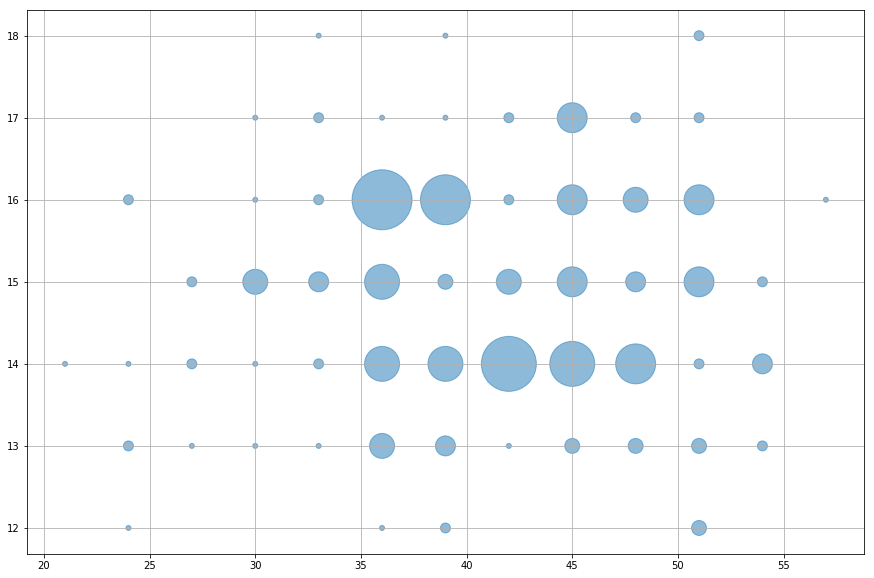

In [31]:
s = [float(s['table']['stats']['2']) for s in stats]
c = collections.Counter(zip(s, g))
sta_, gov_, sz = zip(*[(k[0], k[1], (10*v)) for k,v in c.items()])

fig, ax = plt.subplots()
ax.scatter(sta_, gov_, s=sz, alpha=.5)
ax.grid(True)
ax.set_xlabel('average score in game')
ax.set_ylabel('govenors during game')

plt.show()

In [ ]:
pprint([s for s in stats if s['table']['stats']['2'] < 5][:10], depth=3, width=100)
# len(stats)

In [20]:
def countRoles(log):
    lst = [(s['args']['player_name'], s['args']['rol_type']) for s in steps(log) if s['type'] == 'roleSelected']
    result = [{'name': k[0], 'role':k[1], 'count':c} for k,c in collections.Counter(lst).items()]
    return result

In [21]:
pd.DataFrame([countRoles(l) for l in logs]).head(4)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,"{'name': 'Santis', 'role': 'settler', 'count': 4}","{'name': 'JonathanGett', 'role': 'mayor', 'cou...","{'name': 'Luq B1', 'role': 'builder', 'count': 3}","{'name': 'Ellendir', 'role': 'prospector', 'co...","{'name': 'JonathanGett', 'role': 'builder', 'c...","{'name': 'Luq B1', 'role': 'settler', 'count': 2}","{'name': 'Ellendir', 'role': 'mayor', 'count': 3}","{'name': 'Santis', 'role': 'trader', 'count': 2}","{'name': 'Luq B1', 'role': 'captain', 'count': 6}","{'name': 'Santis', 'role': 'mayor', 'count': 3}",...,"{'name': 'Santis', 'role': 'prospector', 'coun...","{'name': 'Luq B1', 'role': 'mayor', 'count': 2}","{'name': 'Ellendir', 'role': 'builder', 'count...","{'name': 'Luq B1', 'role': 'craftsman', 'count...","{'name': 'Santis', 'role': 'captain', 'count': 1}","{'name': 'Ellendir', 'role': 'captain', 'count...","{'name': 'Luq B1', 'role': 'prospector', 'coun...","{'name': 'JonathanGett', 'role': 'captain', 'c...",None,None
1,"{'name': 'alexpan', 'role': 'settler', 'count'...","{'name': 'DogLovesGafs', 'role': 'builder', 'c...","{'name': 'djk8', 'role': 'mayor', 'count': 3}","{'name': 'plummeting_sloth', 'role': 'craftsma...","{'name': 'DogLovesGafs', 'role': 'captain', 'c...","{'name': 'djk8', 'role': 'prospector', 'count'...","{'name': 'plummeting_sloth', 'role': 'builder'...","{'name': 'alexpan', 'role': 'trader', 'count': 2}","{'name': 'djk8', 'role': 'settler', 'count': 2}","{'name': 'plummeting_sloth', 'role': 'mayor', ...",...,"{'name': 'djk8', 'role': 'trader', 'count': 1}","{'name': 'plummeting_sloth', 'role': 'captain'...","{'name': 'DogLovesGafs', 'role': 'settler', 'c...","{'name': 'djk8', 'role': 'builder', 'count': 4}","{'name': 'DogLovesGafs', 'role': 'trader', 'co...","{'name': 'djk8', 'role': 'captain', 'count': 1}","{'name': 'plummeting_sloth', 'role': 'settler'...","{'name': 'alexpan', 'role': 'mayor', 'count': 1}",None,None
2,"{'name': 'greenBG', 'role': 'settler', 'count'...","{'name': 'Anibal_PA', 'role': 'builder', 'coun...","{'name': 'ola__', 'role': 'mayor', 'count': 3}","{'name': 'tweedledee', 'role': 'prospector', '...","{'name': 'Anibal_PA', 'role': 'settler', 'coun...","{'name': 'ola__', 'role': 'craftsman', 'count'...","{'name': 'tweedledee', 'role': 'captain', 'cou...","{'name': 'greenBG', 'role': 'mayor', 'count': 1}","{'name': 'ola__', 'role': 'trader', 'count': 1}","{'name': 'tweedledee', 'role': 'builder', 'cou...",...,"{'name': 'tweedledee', 'role': 'settler', 'cou...","{'name': 'ola__', 'role': 'prospector', 'count...","{'name': 'tweedledee', 'role': 'mayor', 'count...","{'name': 'greenBG', 'role': 'trader', 'count': 3}","{'name': 'Anibal_PA', 'role': 'captain', 'coun...","{'name': 'Anibal_PA', 'role': 'trader', 'count...","{'name': 'ola__', 'role': 'builder', 'count': 1}","{'name': 'ola__', 'role': 'settler', 'count': 1}",None,None
3,"{'name': 'spaceballs', 'role': 'builder', 'cou...","{'name': 'TrazomX', 'role': 'settler', 'count'...","{'name': 'Aliwart ', 'role': 'mayor', 'count': 3}","{'name': 'monkeymors', 'role': 'prospector', '...","{'name': 'TrazomX', 'role': 'builder', 'count'...","{'name': 'Aliwart ', 'role': 'craftsman', 'cou...","{'name': 'monkeymors', 'role': 'settler', 'cou...","{'name': 'spaceballs', 'role': 'mayor', 'count...","{'name': 'Aliwart ', 'role': 'trader', 'count'...","{'name': 'monkeymors', 'role': 'craftsman', 'c...",...,"{'name': 'monkeymors', 'role': 'captain', 'cou...","{'name': 'Aliwart ', 'role': 'prospector', 'co...","{'name': 'spaceballs', 'role': 'craftsman', 'c...","{'name': 'TrazomX', 'role': 'captain', 'count'...","{'name': 'TrazomX', 'role': 'craftsman', 'coun...","{'name': 'TrazomX', 'role': 'trader', 'count': 1}",None,None,None,None


In [36]:
df_table = json_normalize(data=stats).drop(columns=['result']).set_index('table_id')
df_table.head(5)

,table.concede,table.disagreement,table.neutralized,table.stats.1,table.stats.10,table.stats.11,table.stats.12,table.stats.13,table.stats.14,table.stats.15,table.stats.16,table.stats.2,table.stats.3,table.stats.4
table_id,,,,,,,,,,,,,,
44160632,False,False,0,4,0,7,75,16,0,14,0,58.00,66,NaN
44124319,False,False,0,4,0,11,68,24,1,14,0,56.50,72,NaN
44263507,False,False,0,4,0,0,62,14,2,13,0,56.00,59,NaN
44146821,False,False,0,4,0,0,80,13,3,14,0,55.50,58,NaN
44126722,False,False,0,4,6,3,76,14,0,10,0,54.75,73,NaN


In [37]:
df_player = json_normalize(data=stats, record_path=['result'], meta='table_id')
df_player = pd.concat([df_player.drop(columns=['stats', 'color', 'color_back']), pd.DataFrame(df_player['stats'].tolist())], axis=1).set_index(['table_id', 'player'])
df_player.head(12)

concede        name  rank score score_aux    tie  zombie  \
table_id player                                                               
44160632 5770116         0      kostra     1    66         7  False       0   
         57797129        0     kanchoh     2    60         0  False       0   
         84692900        0  captgroggy     3    59         4  False       0   
         84917414        0         BMN     4    47         0  False       0   
44124319 23410313        0      Krunch     1    72         8  False       0   
         48149493        0     Bonansa     2    66         0  False       0   
         83896089        0     zoundra     3    48         2  False       0   
         84835410        0      Niro90     4    40         8  False       0   
44263507 84062721        0     solan 1     1    59        11  False       0   
         84762006        0   Batman917     2    59         7  False       0   
         84722109        0      itsuca     3    58         2  False       0   
         84616666        0        Sulu     4    48         8  False       0   

                         1  10  11  12  13 14  15  16 17  18 19  
table_id player                                                  
44160632 5770116   11.5333  29  24  13   6  1  20   7  3   8  2  
         57797129     15.7  33  20   7   0  0  17   9  1   8  1  
         84692900  24.2833  34  20   5   3  1  15   9  1   7  1  
         84917414  15.9167  23  17   7   0  0  20   9  3   7  1  
44124319 23410313  11.2833  38  22  12   8  0  13   8  0   8  2  
         48149493        6  44  22   0   0  0  15   5  3  10  0  
         83896089      9.6  11  24  13   2  0  22   4  4   6  3  
         84835410  18.9167  31   9   0   7  1  18   9  0   6  0  
44263507 84062721      7.2  28  22   9  11  0  17   9  1   8  1  
         84762006  11.4333  29  22   8   5  2  24   9  1   9  1  
         84722109    12.75  33  18   7   1  1  17  10  2   7  1  
         84616666  8.98334  16  22  10   6  2  21   8  2   7  2

In [25]:
d = [[
    int(p['rank']),
    int(p['stats']['10']),
    int(p['stats']['11']),     
    int(p['stats']['12'])    
] for game in stats for p in game['result']]
d = list(zip(*d))

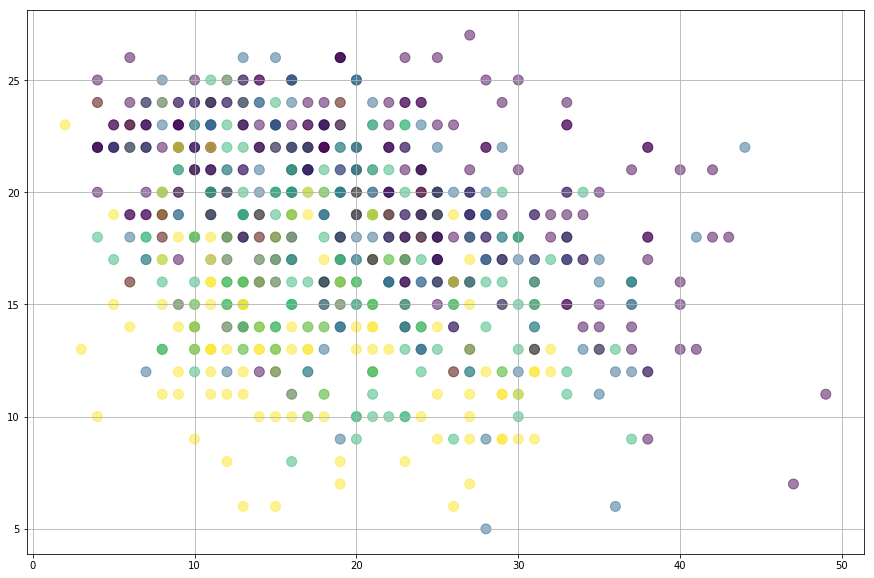

In [35]:
fig, ax = plt.subplots()
ax.scatter(d[1], d[2], c=d[0], s=100, alpha=0.5)
ax.grid(True)
plt.show()

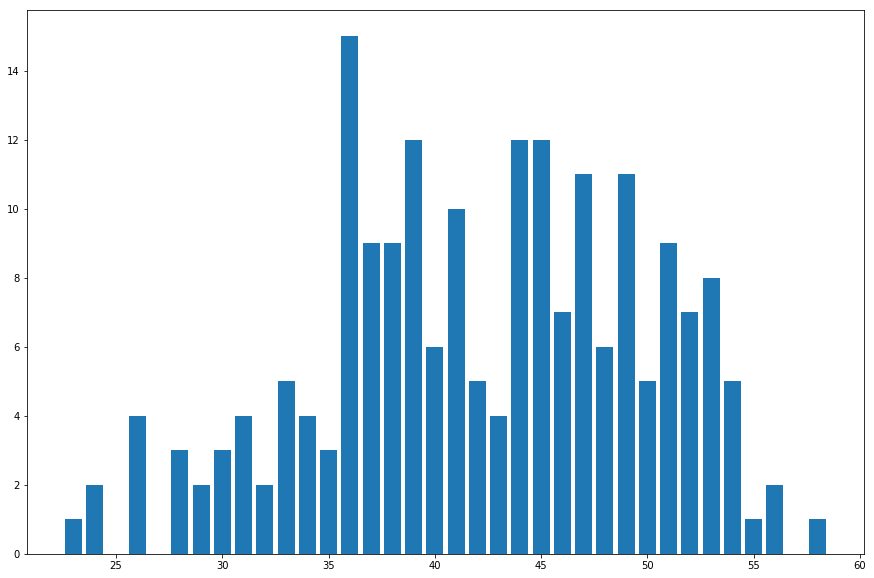

In [33]:
avg = [int(p['table']['stats']['2']) for p in stats]
count = collections.Counter(avg)
plt.bar([x for x in count.keys()], [x for x in count.values()])
plt.show()

In [28]:
pprint(stat, width=width)

{'result': [{'color': '0000ff',
             'color_back': None,
             'concede': 0,
             'name': 'djk8',
             'player': '84883054',
             'rank': 1,
             'score': '55',
             'score_aux': '3',
             'stats': {'1': '8.3', '10': '17', '11': '23', '12': 15, '13': '2', '14': '1', '15': '17', '16': '5', '17': '2', '18': '6', '19': '3'},
             'tie': False,
             'zombie': 0},
            {'color': 'ffa500',
             'color_back': None,
             'concede': 0,
             'name': 'plummeting_sloth',
             'player': '84886155',
             'rank': 2,
             'score': '42',
             'score_aux': '1',
             'stats': {'1': '9.23334', '10': '20', '11': '17', '12': 5, '13': '0', '14': '1', '15': '17', '16': '6', '17': '1', '18': '7', '19': '1'},
             'tie': False,
             'zombie': 0},
            {'color': 'ff0000',
             'color_back': None,
             'concede': 0,
           

In [29]:
table_stats = {
     '1': '_',
     '4': 'Game duration',
     '3': 'Players average level',
     '2': 'Average score',
    '10': 'Unclaimed victory points',
    '11': 'Unclaimed colonists',
    '12': 'Doubloons in the bank',
    '13': 'Unclaimed plantations',
    '14': 'Unclaimed quarries',
    '15': 'Unclaimed small buildings',
    '16': 'Unclaimed large buildings'}

player_stats = {
     '1': 'Thinking time',
    '10': 'VPs earned by shipping',
    '11': 'VPs earned by building',
    '12': 'VPs earned from large buildings',
    '13': 'Doubloons owned at game end',
    '14': 'Good barrels owned at game end',
    '15': 'Colonists',
    '16': 'Plantations',
    '17': 'Quarries',
    '18': 'Small buildings',
    '19': 'Large buildings'}

tdf = pd.DataFrame([table_stats, stat['table']['stats']]).T
pdf = pd.DataFrame(
    data  = [player_stats] + [x['stats']  for x in stat['result']], 
    index =       ['name'] + [x['player'] for x in stat['result']]
).T

display_side_by_side(pdf, tdf)

,name,84883054,84886155,84411056,84896724
1,Thinking time,8.3,9.23334,11.8,11.8167
10,VPs earned by shipping,17,20,10,16
11,VPs earned by building,23,17,18,13
12,VPs earned from large buildings,15,5,5,0
13,Doubloons owned at game end,2,0,4,4
14,Good barrels owned at game end,1,1,2,0
15,Colonists,17,17,20,16
16,Plantations,5,6,5,4
17,Quarries,2,1,2,3
18,Small buildings,6,7,7,7


In [ ]:
group = ['scoreShippingPoints', 'scoreConditionalPoints', 'scoreEndPoints', 'buildingBought']
selected = [s for s in steps(game_log) if s['type'] in group]
argsByType = lambda t: [s['args'] for s in selected if s['type'] == t]

buildings = {s['bld_id']: {
    'player_id': s['player_id'], 
    'building': s['bld_type_tr'],
    'score': int(s['score_delta'])
} for s in argsByType('buildingBought')}

buildings_score = {}
for b in buildings.values():
    buildings_score.setdefault(b['player_id'], 0)
    buildings_score[b['player_id']] += b['score']

JSON({
    'shipping'   : {s['player_id']: int(s['score_delta']) for s in argsByType('scoreShippingPoints')},
    'conditional': {s['building_name']: {
        s['player_id']: int(s['score_delta'])
    } for s in argsByType('scoreConditionalPoints')},
    'endScore'   : {s['player_id']: int(s['score_delta']) for s in argsByType('scoreEndPoints')},
    'buildings_s': buildings_score,
    'buildings'  : buildings
}, width=width)

In [ ]:
flat = [s for s in steps(game_log) if s['type'] not in ['gameStateChange', 'message', 'updateReflexionTime']]
c = collections.Counter([s['type'] for s in flat])
c.most_common(20)